In [318]:
# Importing various packages
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor

In [319]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, color_codes=True)

Define common user defined functions to be used

In [320]:
def display_box_plot(in_df):
    import seaborn as sns
    sns.boxplot(data=in_df, orient="h", palette="Set2")
    return None 

In [321]:
def remove_extreme_outliers(in_df):
    import pandas as pd
    # Calculate Q1 value using quantile(0.05)
    Q1 = in_df.quantile(q=0.05)
    # Calculate Q3 value using quantile value (0.95)
    Q3 = in_df.quantile(q=0.95)
    # Calculate Inter Quartile Range
    IQR = Q3 - Q1
    #print(IQR)
    #print(Q1 - IQR)
    #print(Q3 + IQR)
    #print(in_df[(in_df < (Q1 - 3*IQR)).any(axis=1)])
    #print(in_df[(in_df > (Q3 + 3*IQR)).any(axis=1)])
    #print(in_df[((in_df < (Q1 - 3*IQR))|(in_df > (Q3 + 3*IQR))).any(axis=1)])
    out_df = in_df[~((in_df < (Q1 - 3*IQR))|(in_df > (Q3 + 3*IQR))).any(axis=1)]
    return out_df

In [322]:
def apply_standard_scalar(X_df):
    from sklearn.preprocessing import StandardScaler
    X_df = pd.DataFrame(StandardScaler().fit_transform(X_df), columns=X_df.columns)
    return X_df

In [323]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

# Initialize dictionary to store error metrics for different models
scores = {}

In [324]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

__Points to Consider__ </br>
There should be a metadata datastructure (written to a file for persistance), covering the permitted range or set of values for each feature column. </br>
However, since we do not have a lot of train data, the data given for prediction has a size of the same order and there are quite a few columns for which MAR (Missing value may be imputed based on the value present in some other column) situation is present, hence we do not create generalized methods for missing value imputation at this initial point in the life cycle. </br>
During training phase, we do the train and test split only after the basic missing value imputation because of the same reasons as the above point. </br>
We create methods and include them to a pre-processing pipeline for steps like column transformation, feature engineering, encoding and scaling. </br>
Once the metadata is in place, for any new data that comes in for prediction, we will be removing all entries with column values out of range or set of known values and then sending it to our model for prediction. </br>
On similar lines, if some known value is missing, we will create a dummy (empty) column for that before sending the data to our model. </br>
Future scope is creating a dashboard to track all these changes coming in for new data (on which prediction is to be made) over a period of time. This will help us take an informed decision on when the model has to be re-trained and what data.

____
__EDA, Pre Processing & Training the Model__
--
____

In [325]:
train_df = pd.read_csv('https://raw.githubusercontent.com/realsayan/Simple-Datasets/master/HousePricesTrain.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
!pip install pandas-profiling --upgrade

In [ ]:
import pandas_profiling 
from google.colab import files
# To output pandas profiling report to an external html file.
# Saving the output as profiling_before_preprocessing.html

profile = train_df.profile_report(title='Pandas Profiling before Data Preprocessing')
profile.to_file("/tmp/profiling_before_preprocessing.html")

files.download('/tmp/profiling_before_preprocessing.html')

# To output the pandas profiling report on the notebook.

# train_df.profile_report(title='Pandas Profiling before Data Preprocessing')

In [ ]:
train_df.info()

In [ ]:
train_df.MSSubClass.unique()

In [ ]:
train_df.MSZoning.unique()

__Missing Value Impuatation for LotFrontage__

In [326]:
train_df[train_df['LotFrontage'].notnull()][['LotFrontage','LotArea']].corr()

,LotFrontage,LotArea
LotFrontage,1.000000,0.426095
LotArea,0.426095,1.000000


Correlation between the columns _LotFrontage_ and _LotArea_ is insignificant.

We will try out the following hypothesis:- </br>
- Use the column _Neighborhood_ to derive the missing values. For each type of _Neighborhood_ we take the mean to fill up the _LotFrontage_ column.
- Use KNN Imputer to predict the missing values - this is future scope

In [327]:
initial_df = train_df.copy()

In [328]:
mean_df = pd.DataFrame(train_df.groupby('Neighborhood')['LotFrontage'].mean().round()).reset_index()
mean_df
left_df = pd.DataFrame(initial_df.loc[initial_df['LotFrontage'].isnull(),'Neighborhood']).reset_index()
left_df
merged_df = pd.merge(left=left_df, right=mean_df, how='left', on='Neighborhood').set_index('index')['LotFrontage']
merged_df

index
7       81.0
12      74.0
14      76.0
16      76.0
24      74.0
        ... 
1429    81.0
1431    32.0
1441    72.0
1443    58.0
1446    70.0
Name: LotFrontage, Length: 259, dtype: float64

In [329]:
initial_df.loc[initial_df['LotFrontage'].isnull(),'LotFrontage'] = merged_df

In [330]:
initial_df['LotFrontage'].isnull().sum()

0

__Missing Value Imputation for Alley__

In [331]:
print('Percentage Not Null values in column Alley: ',(initial_df['Alley'].count()/initial_df['Id'].count())*100)

Percentage Not Null values in column Alley:  6.232876712328768


Column _Alley_ has only 6% of not null values. However, presence of alley is rare. Hence null values actually mean there is no alley for that house. We fill up the null values with the string "NA".

In [332]:
initial_df.fillna({'Alley':'NA'},inplace=True)

In [333]:
initial_df['Alley'].value_counts()

NA      1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

__Missing Value Imputation for MasVnrType and MasVnrArea__

In [334]:
initial_df['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [335]:
initial_df['MasVnrArea'].value_counts()

0.0      861
72.0       8
180.0      8
108.0      8
120.0      7
        ... 
651.0      1
337.0      1
415.0      1
293.0      1
621.0      1
Name: MasVnrArea, Length: 327, dtype: int64

In [336]:
initial_df.fillna({'MasVnrType':'None', 'MasVnrArea':0.0},inplace=True)

The small number of records that are Null for columns _MasVnrType_ and _MasVnrArea_ are replaced by the respective mode values. </br>'None' is the most common type with 864 occurances and out of them 861 have area value as 0.0.

__Missing Value Imputation for Basement related columns__

In [337]:
initial_df.BsmtQual.value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [338]:
initial_df.BsmtCond.value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [339]:
initial_df.BsmtExposure.value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [340]:
initial_df[initial_df.BsmtExposure.isnull() & initial_df.BsmtQual.notnull()][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
948,Gd,TA,NaN,Unf,0,Unf,0,936,936


In [341]:
initial_df.BsmtFinType1.value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [342]:
initial_df[initial_df.BsmtFinType1.isnull()]['BsmtFinSF1'].value_counts()

0    37
Name: BsmtFinSF1, dtype: int64

In [343]:
initial_df[(initial_df.BsmtFinType1.notnull()) & (initial_df.BsmtFinSF1==0)].BsmtFinType1.value_counts()

Unf    430
Name: BsmtFinType1, dtype: int64

In [344]:
initial_df.BsmtFinType2.value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [345]:
initial_df[initial_df.BsmtFinType2.isnull() & initial_df.BsmtQual.notnull()][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
332,Gd,TA,No,GLQ,1124,NaN,479,1603,3206


In [346]:
initial_df[initial_df.BsmtFinType2.isnull()]['BsmtFinSF2'].value_counts()

0      37
479     1
Name: BsmtFinSF2, dtype: int64

In [347]:
initial_df[(initial_df.BsmtFinType2.notnull()) & (initial_df.BsmtFinSF2==0)].BsmtFinType2.value_counts()

Unf    1256
Name: BsmtFinType2, dtype: int64

In [348]:
initial_df[initial_df.BsmtUnfSF==0][['BsmtFinType1','BsmtFinType2']].drop_duplicates()

,BsmtFinType1,BsmtFinType2
17,NaN,NaN
42,ALQ,LwQ
52,LwQ,GLQ
54,ALQ,Unf
75,GLQ,Unf
202,LwQ,Unf
233,LwQ,ALQ
260,Rec,ALQ
273,Rec,LwQ
352,LwQ,Rec


In [349]:
initial_df[(initial_df.TotalBsmtSF)!=(initial_df.BsmtFinSF1 + initial_df.BsmtFinSF2 + initial_df.BsmtUnfSF)]['Id'].count()

0

All the Basement related textual columns have at least 37 null values. This indicates that no basement information was available for them. Even the Basement related metrics like _BsmtFinSF1_ and _BsmtFinSF2_ have 0 values for these entries. We conclude that there are no Basement information available for them.</br>
- Columns _BsmtQual_, _BsmtCond_, _BsmtExposure_, _BsmtFinType1_ and _BsmtFinType2_ are imputed by the value 'NA' for the 37 rows.
- One extra null entry in column _BsmtExposure_ is replaced by 'No' (No Exposure) because we find from other column values that Basement is available.
- One extra null entry in column _BsmtFinType2_ is replaced by 'Rec' (Average Rec Room) - the mode value of the column excluding 'Unf'. Since for this row, we have valid value in the column _BsmtFinSF2_ we can not state that the corresponding type column, which is _BsmtFinType2_, is Unfinished ('Unf')
- We find that for the complete dataset the value in column _TotalBsmtSF_ is always equal to the sum of the value in columns _BsmtFinSF1_, _BsmtFinSF2 and _BsmtUnfSF_. Hence the information contained in the column is redundant and we should drop the column.

In [350]:
initial_df.loc[initial_df.BsmtQual.isnull(),['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = 'NA'

In [351]:
initial_df[initial_df.BsmtQual=='NA'][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']].drop_duplicates()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
17,NA,NA,NA,NA,NA


In [352]:
initial_df.loc[initial_df.BsmtExposure.isnull(),'BsmtExposure'] = 'No'

In [353]:
initial_df.BsmtExposure.value_counts()

No    954
Av    221
Gd    134
Mn    114
NA     37
Name: BsmtExposure, dtype: int64

In [354]:
initial_df.loc[initial_df.BsmtFinType2.isnull(),'BsmtFinType2'] = 'Rec'

In [355]:
initial_df.BsmtFinType2.value_counts()

Unf    1256
Rec      55
LwQ      46
NA       37
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [356]:
initial_df.drop('TotalBsmtSF', axis=1, inplace=True)

__Missing Value Imputation for Electrical__

In [357]:
initial_df.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Column _Electrical_ has the value 'SBrkr' as mode. Hence we impute the row with missing value with 'SBrkr'

In [358]:
initial_df.Electrical.mode()

0    SBrkr
dtype: object

In [359]:
initial_df.fillna({'Electrical':'SBrkr'}, inplace=True)

__Missing Value Imputatipn for FireplaceQu__

In [360]:
initial_df.FireplaceQu.value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [361]:
initial_df[initial_df.FireplaceQu.isnull()].Fireplaces.value_counts()

0    690
Name: Fireplaces, dtype: int64

In [362]:
initial_df[(initial_df.FireplaceQu.isnull()) & (initial_df.Fireplaces==0)]['Id'].count()

690

Column _FireplacesQu_ has 690 rows with null value. </br>
These 690 rows also have count of Fireplace as 0 (column _Fireplaces_ is 0).</br> This confirms that, these 690 rows actually represent houses which do not have Fireplace. Hence we impute them with the value 'NA'.

In [363]:
initial_df.fillna({'FireplaceQu':'NA'}, inplace=True)

In [364]:
initial_df.FireplaceQu.value_counts()

NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

__Missing Value Imputation for Garage related columns__

In [365]:
initial_df.GarageType.value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [366]:
initial_df.GarageType.isnull().sum()

81

In [367]:
initial_df[initial_df.GarageType.isnull()].GarageYrBlt.unique()

array([nan])

In [368]:
initial_df[initial_df.GarageYrBlt==0].GarageYrBlt.count()

0

In [369]:
initial_df.GarageYrBlt.unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

In [370]:
initial_df.fillna({'GarageYrBlt':0}, inplace=True)

In [371]:
initial_df.GarageYrBlt = initial_df.GarageYrBlt.astype(int)

In [372]:
initial_df.GarageFinish.value_counts()

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [373]:
initial_df[initial_df.GarageType.isnull()].GarageCars.unique()

array([0])

In [374]:
initial_df[initial_df.GarageCars==0].GarageType.unique()

array([nan], dtype=object)

In [375]:
initial_df[initial_df.GarageType.isnull()].GarageArea.unique()

array([0])

In [376]:
initial_df[initial_df.GarageArea==0].GarageType.unique()

array([nan], dtype=object)

In [377]:
initial_df.GarageQual.value_counts()

TA    1311
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

In [378]:
initial_df.GarageCond.value_counts()

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

All the garage related textual columns have 81 null values. This indicates that no garage information was available for them. Even the garage related numeric columns like _GarageCars_ and _GarageArea_ have 0 values for these entries. We conclude that there are no garage information available for them. </br>
- Columns _GarageType_, _GarageFinish_, _GarageQual_ and _GarageCond_ are imputed by the value 'NA' for the 81 rows.

In [379]:
initial_df.loc[initial_df.GarageType.isnull(),['GarageType','GarageFinish','GarageQual','GarageCond']] = 'NA'

__Missing Value Imputation for PoolQC__

In [380]:
initial_df.PoolQC.value_counts()

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

In [381]:
initial_df[(initial_df.PoolQC.notnull()) & (initial_df.PoolArea==0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [382]:
initial_df[(initial_df.PoolQC.isnull()) & (initial_df.PoolArea==0)]['PoolArea'].count()

1453

In [383]:
print("Percentage of not null records of PoolQC : ",(initial_df.PoolQC.notnull().sum()*100/len(initial_df.PoolQC)))

Percentage of not null records of PoolQC :  0.4794520547945205


Column _PoolQC_ has valid value for only 7 rows.</br> For every other row (remaining 1453), the column _PoolArea_ has 0 value.</br> This means that only 7 houses have swimming pools.</br>
Hence only 0.479 % of the total records have valid value of _PoolQC_ which is insignificant for any learning.</br>
So instead of any imputation, we remove _PoolQC_ and consequently also _PoolArea_.

In [384]:
#initial_df.fillna({'PoolQC':'NA'}, inplace=True) #Decided against this as all 7 valid values were getting removed during extreme outlier removal

In [385]:
initial_df.drop(['PoolQC','PoolArea'], axis=1, inplace=True)

__Missing Value Imputation for Fence__

In [386]:
initial_df.Fence.value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [387]:
initial_df.Fence.isnull().sum()

1179

Column _Fence_ has majority (1179) rows as null. This sounds logical because houses having fence are not that common. The data description also mentions a category 'NA' for such cases. Hence we will impute the column with 'NA'.

In [388]:
initial_df.fillna({'Fence':'NA'}, inplace=True)

__Missing Value Imputation of MiscFeature__

In [389]:
initial_df.MiscFeature.value_counts()

Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

In [390]:
initial_df[(initial_df.MiscFeature.notnull()) & (initial_df.MiscVal==0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
873,874,40,RL,60.0,12144,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1949,1950,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,Rec,375,Unf,0,457,GasA,Gd,Y,SBrkr,1036,0,232,1268,0,0,1,0,3,1,TA,6,Typ,1,Gd,Attchd,1949,Unf,1,288,TA,TA,Y,0,28,0,0,0,NA,Othr,0,9,2009,WD,Normal,133000
1200,1201,20,RL,71.0,9353,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,864,GasA,Gd,Y,SBrkr,864,0,0,864,0,0,1,0,3,1,TA,5,Typ,0,NA,Attchd,1972,Unf,1,280,TA,TA,Y,0,0,0,0,0,NA,Shed,0,7,2006,Oth,Abnorml,116050


In [391]:
initial_df[(initial_df.MiscFeature.isnull()) & (initial_df.MiscVal==0)]['MiscVal'].count()

1406

Column _MiscFeature_ has majority (1406) rows as null. This sounds logical because houses having miscellaneous features are not that common. The data description also mentions a category 'NA' for such cases. Hence we will impute the column with 'NA'.

In [392]:
initial_df.fillna({'MiscFeature':'NA'}, inplace=True)

__Check not null record distribution for all columns after Missing Value Treatment__

In [393]:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

__Check Distribution of Y column "SalePrice"__

In [394]:
initial_df[initial_df['SalePrice']==0]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


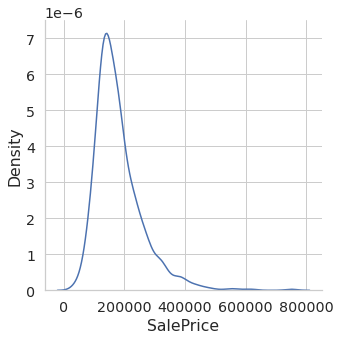

In [395]:
sns.displot(initial_df, x='SalePrice', kind='kde') #the KDE clearly indicates that there are outliers on the higher end of 'SalePrice' scale.

In [396]:
initial_df['SalePrice'].skew() #skew is beyond acceptible range of [-1,1]

1.8828757597682129

In [397]:
initial_df['SalePrice'].kurt() #kurtosis is beyond acceptible range of [-5,5]

6.536281860064529

In [398]:
np.log1p(initial_df['SalePrice']).skew()

0.12134661989685333

In [399]:
np.log1p(initial_df['SalePrice']).kurt()

0.809519155707878

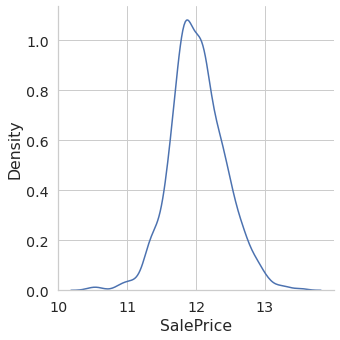

In [400]:
sns.displot(np.log1p(initial_df['SalePrice']), kind='kde')

In [401]:
initial_df['SalePrice'][:10]

0    208500
1    181500
2    223500
3    140000
4    250000
5    143000
6    307000
7    200000
8    129900
9    118000
Name: SalePrice, dtype: int64

In [402]:
initial_df['SalePrice'] = initial_df['SalePrice'].apply(np.log1p)

In [403]:
initial_df['SalePrice'][:10]

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
5    11.870607
6    12.634606
7    12.206078
8    11.774528
9    11.678448
Name: SalePrice, dtype: float64

__Feature Engineering, Transformations, Outlier Detection & Encoding__

In [404]:
initial_df.MSSubClass.unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40])

In [405]:
initial_df.MSSubClass = initial_df.MSSubClass.astype(str)

Feature Engineering

In [406]:
# Let us drop the column 'Id' that has no significance from prediction perspective
initial_df.drop(['Id'], axis=1, inplace=True)

In [407]:
initial_df[['YearBuilt','YearRemodAdd']].corr()

,YearBuilt,YearRemodAdd
YearBuilt,1.000000,0.592855
YearRemodAdd,0.592855,1.000000


The correlation between Year of Built and Year of Remodel is not high enough to be marked as redundant information. So we keep both the columns.

In [408]:
initial_df[['YearBuilt','YrSold']].corr()

,YearBuilt,YrSold
YearBuilt,1.000000,-0.013618
YrSold,-0.013618,1.000000


There is no correlation between Year of Built and Year of Sale. Later we may experiment by keeping only the difference between the columns instead of both columns.

Check for outliers using Box Plot

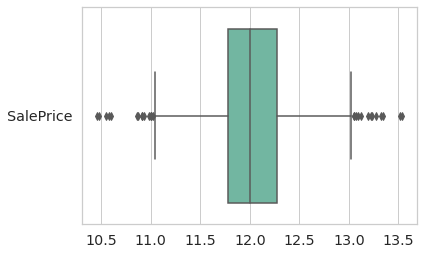

In [409]:
display_box_plot(initial_df[['SalePrice']])

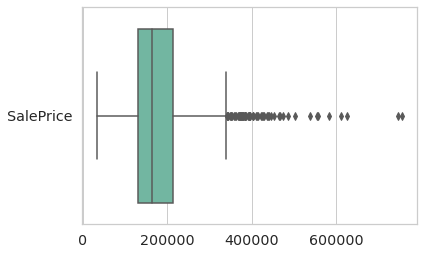

In [410]:
display_box_plot(initial_df[['SalePrice']].apply(np.expm1)) #just checking outlier distribution if we had not taken log1p of column 'SalePrice'

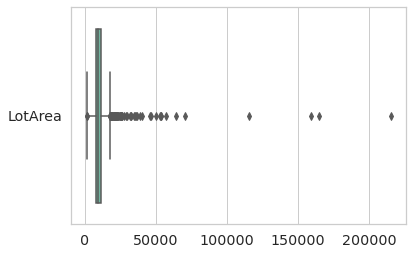

In [411]:
display_box_plot(initial_df[['LotArea']]) #checking outlier distribution of column 'LotArea'

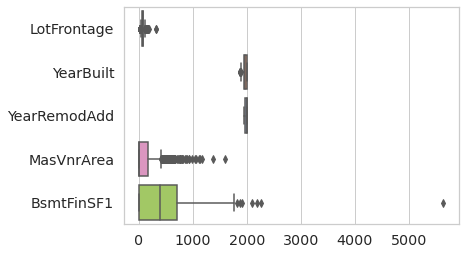

In [412]:
display_box_plot(initial_df[['LotFrontage','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1']]) #checking outlier distribution of columns 'LotFrontage','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1'

Identify and remove extreme outliers (less than Q1-3IQR or greater than Q3+3IQR)

In [413]:
out_df = remove_extreme_outliers(initial_df)
print (out_df)

     MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition  SalePrice
0            60       RL         65.0  ...        WD        Normal  12.247699
1            20       RL         80.0  ...        WD        Normal  12.109016
2            60       RL         68.0  ...        WD        Normal  12.317171
3            70       RL         60.0  ...        WD       Abnorml  11.849405
4            60       RL         84.0  ...        WD        Normal  12.429220
...         ...      ...          ...  ...       ...           ...        ...
1454         20       FV         62.0  ...        WD        Normal  12.128117
1455         60       RL         62.0  ...        WD        Normal  12.072547
1456         20       RL         85.0  ...        WD        Normal  12.254868
1458         20       RL         68.0  ...        WD        Normal  11.864469
1459         20       RL         75.0  ...        WD        Normal  11.901590

[1294 rows x 77 columns]


__Collect Metadata__

In [414]:
out_df['MSSubClass'].unique()

array(['60', '20', '70', '45', '120', '30', '85', '50', '90', '80', '160',
       '75', '180', '40', '190'], dtype=object)

In [415]:
metadata_dict = {}
max_length = 0

In [416]:
for i in out_df.columns:
  if out_df[i].dtype=='O':
    metadata_dict[i] = list(out_df[i].unique())
    print(metadata_dict[i])
    if len(metadata_dict[i]) > max_length:
      max_length = len(metadata_dict[i])

['60', '20', '70', '45', '120', '30', '85', '50', '90', '80', '160', '75', '180', '40', '190']
['RL', 'RM', 'C (all)', 'FV', 'RH']
['Pave', 'Grvl']
['NA', 'Grvl', 'Pave']
['Reg', 'IR1', 'IR2', 'IR3']
['Lvl', 'Bnk', 'Low', 'HLS']
['AllPub', 'NoSeWa']
['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3']
['Gtl', 'Mod', 'Sev']
['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Somerst', 'Sawyer', 'NridgHt', 'NAmes', 'BrkSide', 'SawyerW', 'IDOTRR', 'MeadowV', 'Timber', 'Mitchel', 'Gilbert', 'StoneBr', 'OldTown', 'ClearCr', 'Edwards', 'NWAmes', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU', 'Blueste']
['Norm', 'Feedr', 'RRAe', 'RRNn', 'RRAn', 'PosA', 'Artery', 'PosN', 'RRNe']
['Norm', 'RRNn', 'Feedr', 'PosN', 'PosA']
['1Fam', 'TwnhsE', 'Duplex', 'Twnhs', '2fmCon']
['2Story', '1Story', '1.5Unf', 'SFoyer', '1.5Fin', 'SLvl', '2.5Unf', '2.5Fin']
['Gable', 'Hip', 'Gambrel', 'Flat', 'Mansard', 'Shed']
['CompShg', 'WdShngl', 'WdShake', 'Membran', 'Tar&Grv']
['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'WdShing', 'Br

In [417]:
for i in metadata_dict.keys():
  padding = ['Absent' for j in range(max_length-len(metadata_dict[i]))]
  metadata_dict[i].extend(padding)

#metadata_dict

In [418]:
metadata_df = pd.DataFrame(data=metadata_dict)

In [419]:
metadata_df.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NA,Attchd,RFn,TA,TA,Y,NA,NA,WD,Normal
1,20,RM,Grvl,Grvl,IR1,Bnk,NoSeWa,FR2,Mod,Veenker,Feedr,RRNn,TwnhsE,1Story,Hip,WdShngl,MetalSd,MetalSd,None,TA,Gd,CBlock,TA,Gd,Gd,ALQ,ALQ,GasW,Gd,N,FuseA,TA,Min1,TA,Detchd,Unf,Fa,Fa,N,GdWo,Shed,New,Abnorml
2,70,C (all),Absent,Pave,IR2,Low,Absent,Corner,Sev,Crawfor,RRAe,Feedr,Duplex,1.5Unf,Gambrel,WdShake,Wd Sdng,Wd Shng,Stone,Ex,Fa,BrkTil,Ex,Fa,Mn,Rec,Rec,Grav,TA,Absent,FuseF,Ex,Maj1,Gd,BuiltIn,Fin,NA,Gd,P,GdPrv,Absent,COD,Partial
3,45,FV,Absent,Absent,IR3,HLS,Absent,CulDSac,Absent,NoRidge,RRNn,PosN,Twnhs,SFoyer,Flat,Membran,HdBoard,HdBoard,BrkCmn,Fa,Ex,Slab,NA,NA,Av,Unf,LwQ,Wall,Fa,Absent,FuseP,Fa,Min2,Fa,CarPort,NA,Gd,NA,Absent,MnPrv,Absent,ConLI,Family
4,120,RH,Absent,Absent,Absent,Absent,Absent,FR3,Absent,Somerst,RRAn,PosA,2fmCon,1.5Fin,Mansard,Tar&Grv,WdShing,Plywood,Absent,Absent,Absent,Stone,Fa,Po,NA,BLQ,BLQ,OthW,Po,Absent,Mix,Absent,Mod,Ex,NA,Absent,Ex,Ex,Absent,MnWw,Absent,CWD,AdjLand


Next step is applying OHE to convert text columns into numerical representation

In [420]:
data_df = pd.get_dummies(out_df, drop_first=True)

In [421]:
X = data_df.drop(['SalePrice'], axis=1)
y = data_df['SalePrice']
print(X.shape)
print(y.shape)


(1294, 256)
(1294,)


In [422]:
X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,...,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_Shed,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,854,0,1710,1,0,2,1,3,1,8,0,2003,2,548,0,61,0,0,0,0,2,2008,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,0,0,1262,0,1,2,0,3,1,6,1,1976,2,460,298,0,0,0,0,0,5,2007,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,866,0,1786,1,0,2,1,3,1,6,1,2001,2,608,0,42,0,0,0,0,9,2008,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,961,756,0,1717,1,0,1,0,3,1,7,1,1998,3,642,0,35,272,0,0,0,2,2006,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000,3,836,192,84,0,0,0,0,12,2008,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


Split the data into train and test

In [423]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

Just before modeling we apply Standard Scalar Transformation on the Independent Variables

In [424]:
X_train = apply_standard_scalar(X_train)
print(X_train.head())

   LotFrontage   LotArea  ...  SaleCondition_Normal  SaleCondition_Partial
0    -0.951683 -0.954150  ...              0.457288              -0.314207
1     0.228287 -0.117179  ...              0.457288              -0.314207
2    -2.178851 -1.428211  ...              0.457288              -0.314207
3    -0.479695 -0.188919  ...              0.457288              -0.314207
4    -0.479695 -0.172850  ...              0.457288              -0.314207

[5 rows x 256 columns]


In [425]:
X_test = apply_standard_scalar(X_test)
print(X_test.head())

   LotFrontage   LotArea  ...  SaleCondition_Normal  SaleCondition_Partial
0    -0.256471  0.315807  ...              0.489116              -0.334048
1     0.241309  0.290016  ...              0.489116              -0.334048
2     0.075383 -0.122107  ...              0.489116              -0.334048
3    -1.086106 -0.331239  ...              0.489116              -0.334048
4    -0.256471  0.413530  ...              0.489116              -0.334048

[5 rows x 256 columns]


Standard Scalar is also applied on the unsplitted data ('X') that we will use when training models based on Cross-Validation method

In [426]:
X = apply_standard_scalar(X)
print(X.head())

   LotFrontage   LotArea  ...  SaleCondition_Normal  SaleCondition_Partial
0    -0.245487 -0.285432  ...              0.463706               -0.31824
1     0.482535 -0.069480  ...              0.463706               -0.31824
2    -0.099883  0.240366  ...              0.463706               -0.31824
3    -0.488161 -0.078869  ...             -2.156538               -0.31824
4     0.676674  0.805598  ...              0.463706               -0.31824

[5 rows x 256 columns]


In [427]:
X_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,...,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_Shed,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.951683,-0.954150,-0.828532,0.410888,-1.701129,-1.753277,-0.582929,-0.524278,-0.291117,0.543550,-0.325880,0.764375,0.0,0.417803,-0.846655,-0.234619,0.827222,-0.788975,0.282674,0.0,-0.256465,0.643699,0.070823,-1.092654,-0.818182,-0.790461,-0.724998,4.172178,0.0,-0.274174,0.0,-0.470975,1.648790,-0.222925,-0.093659,-0.093659,-0.806671,-0.229998,-0.044001,-0.108306,...,-0.509042,-1.310166,-0.098773,-0.256732,-0.062287,1.739896,-0.210712,-0.210712,-0.640376,1.212504,-0.175717,-0.098773,-0.210712,-0.044001,0.304836,-0.154074,-0.082519,-0.210712,-0.062287,0.289430,-0.14391,0.279508,-0.208199,-0.330643,-0.088259,0.47724,-0.031099,-0.053916,-0.044001,-0.062287,-0.044001,-0.062287,-0.310481,-0.044001,0.390591,-0.044001,-0.044001,-0.117098,0.457288,-0.314207
1,0.228287,-0.117179,0.604268,-0.519679,0.993685,0.877980,-0.582929,-1.025681,-0.291117,0.781007,-0.635562,1.961264,0.0,1.218779,-0.846655,-0.234619,0.827222,1.237300,1.649812,0.0,1.064139,0.643699,0.268245,0.289860,0.650983,0.697177,2.025669,-0.349561,0.0,-0.274174,0.0,1.743072,0.887979,-0.222925,-0.093659,-0.093659,-0.806671,-0.229998,-0.044001,-0.108306,...,-0.509042,-1.310166,-0.098773,3.895109,-0.062287,-0.574747,-0.210712,-0.210712,-0.640376,-0.824739,-0.175717,-0.098773,-0.210712,-0.044001,0.304836,-0.154074,-0.082519,-0.210712,-0.062287,0.289430,-0.14391,0.279508,-0.208199,-0.330643,-0.088259,0.47724,-0.031099,-0.053916,-0.044001,-0.062287,-0.044001,-0.062287,-0.310481,-0.044001,0.390591,-0.044001,-0.044001,-0.117098,0.457288,-0.314207
2,-2.178851,-1.428211,0.604268,-0.519679,1.027797,0.877980,-0.310689,-1.025681,-0.291117,0.913436,-0.478004,0.935689,0.0,0.453578,-0.846655,-0.234619,0.827222,-0.788975,0.282674,0.0,0.403837,-0.946345,0.270744,0.289860,-0.473622,-0.790461,-0.120456,-0.349561,0.0,-0.274174,0.0,-0.839983,-1.394451,4.485805,-0.093659,-0.093659,-0.806671,-0.229998,-0.044001,-0.108306,...,-0.509042,-1.310166,-0.098773,-0.256732,-0.062287,1.739896,-0.210712,-0.210712,-0.640376,1.212504,-0.175717,-0.098773,-0.210712,-0.044001,0.304836,-0.154074,-0.082519,-0.210712,-0.062287,0.289430,-0.14391,0.279508,-0.208199,-0.330643,-0.088259,0.47724,-0.031099,-0.053916,-0.044001,-0.062287,-0.044001,-0.062287,-0.310481,-0.044001,0.390591,-0.044001,-0.044001,-0.117098,0.457288,-0.314207
3,-0.479695,-0.188919,-0.112132,-2.380812,-1.564683,-1.753277,-0.582929,-1.025681,-0.291117,0.488752,-0.983276,-0.775145,0.0,-1.384890,-0.846655,-0.234619,-1.017982,-0.788975,-1.084464,0.0,-0.916767,-0.946345,0.135797,0.289860,-0.569333,-0.790461,-0.724998,1.350763,0.0,-0.274174,0.0,1.374064,0.887979,-0.222925,-0.093659,-0.093659,-0.806671,-0.229998,-0.044001,9.233093,...,-0.509042,-1.310166,-0.098773,-0.256732,-0.062287,1.739896,-0.210712,-0.210712,-0.640376,1.212504,5.690966,-0.098773,-0.210712,-0.044001,-3.280452,6.490377,-0.082519,-0.210712,-0.062287,-3.455069,-0.14391,-3.577709,-0.208199,-0.330643,-0.088259,0.47724,-0.031099,-0.053

In [428]:
base_lr_model = LinearRegression()
base_lr_model.fit(X_train, y_train)
print('Base LR Model Score for Train data: ',base_lr_model.score(X_train, y_train))
print('Base LR Model Score for Test data: ',base_lr_model.score(X_test, y_test))
y_pred_train = base_lr_model.predict(X_train)
y_pred_test = base_lr_model.predict(X_test)
#Initial  Base LR Model Score:  0.933513297285893
#Before pool drop hypothesis: 0.9502317727777844

Base LR Model Score for Train data:  0.9547088375730057
Base LR Model Score for Test data:  -2.9268115671106427e+21


In [429]:
y_train[:10]

380     11.751950
549     12.479913
1088    11.831386
383     11.238502
352     11.461643
695     12.078245
372     11.736077
1343    12.083911
231     12.906694
623     12.034697
Name: SalePrice, dtype: float64

In [430]:
y_pred_train[:10]

array([11.93013526, 12.36170723, 11.87458946, 11.30041647, 11.42795023,
       12.06047584, 11.68712694, 12.084085  , 12.83015205, 12.04709388])

In [431]:
y_test[:10]

747     12.491176
538     11.970357
1418    11.728045
284     12.096263
759     12.577640
362     12.198549
1345    11.594515
876     11.792457
1148    11.669083
251     12.367345
Name: SalePrice, dtype: float64

In [432]:
y_pred_test[:10]

array([ 1.56356846e+09, -1.95068021e+09, -1.89848074e+09, -3.39834528e+09,
        1.17457786e+09,  4.76482216e+09, -1.25816735e+09, -1.53656447e+09,
        1.75582225e+09, -3.57234349e+09])

In [433]:
#np.sqrt(mean_squared_error(y_train, y_pred_train))
#Initial  20477.245365401137
print('Base LR Model RMSE for train data: ',np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
#Before pool drop hypothesis: 17603.618590733702
#print('Base LR Model RMSE for test data: ',np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_test))))

Base LR Model RMSE for train data:  17393.68779954375


In [434]:
base_lr_model_fitted = base_lr_model.fit(X, y)
score = cv_rmse(base_lr_model, X)
print("lr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['base_lr_model_fitted'] = (score.mean(), score.std())

lr: 33459250822.1214 (43478222732.5103)


In [435]:
base_lasso_model = Lasso(alpha=0.5, max_iter=10000)
base_lasso_model.fit(X_train, y_train)
print('Base Lasso Model Score: ',base_lasso_model.score(X_train, y_train))
#Initial  Base Lasso Model Score:  0.9335876448041054
y_pred_train = base_lasso_model.predict(X_train)
#np.sqrt(mean_squared_error(y_train, y_pred_train))
#Initial  20465.79301360276
np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train)))
#Before pool drop hypothesis: 80593.41152076224

Base Lasso Model Score:  0.0


81285.91066946805

In [436]:
base_lasso_model_fitted = base_lasso_model.fit(X, y)
score = cv_rmse(base_lasso_model, X)
print("lasso: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['base_lasso_model_fitted'] = (score.mean(), score.std())

lasso: 0.4009 (0.0337)


In [437]:
base_ridge_model = Ridge()
base_ridge_model.fit(X_train, y_train)
print('Base Ridge Model Score: ',base_ridge_model.score(X_train, y_train))
#Initial  Base Ridge Model Score:  0.9333641175602412
y_pred_train = base_ridge_model.predict(X_train)
#np.sqrt(mean_squared_error(y_train, y_pred_train))
#Initial  20500.205431793816
np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train)))
#Before pool drop hypothesis: 17618.844631798413

Base Ridge Model Score:  0.954476681387448


17397.239652963013

In [438]:
base_ridge_model_fitted = base_ridge_model.fit(X, y)
score = cv_rmse(base_ridge_model, X)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['base_ridge_model_fitted'] = (score.mean(), score.std())
#ridge: 0.1277 (0.0284)

ridge: 0.1277 (0.0284)


In [439]:
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
tuned_ridge_model = RidgeCV(alphas=ridge_alphas, cv=kf)

In [440]:
'''
tuned_ridge_model.fit(X, y)
score = cv_rmse(tuned_ridge_model, X)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())
'''
#ridge: 0.1210 (0.0291)
# Ran very long but did not give that great an improvement

'\ntuned_ridge_model.fit(X, y)\nscore = cv_rmse(tuned_ridge_model, X)\nprint("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))\nscores[\'ridge\'] = (score.mean(), score.std())\n'

In [441]:
np.expm1(y_train[:10])

380     127000.0
549     263000.0
1088    137500.0
383      76000.0
352      95000.0
695     176000.0
372     125000.0
1343    177000.0
231     403000.0
623     168500.0
Name: SalePrice, dtype: float64

In [442]:
np.expm1(y_pred_train[:10])

array([150516.09064321, 233347.00972856, 143780.75091221,  81041.87461486,
        91955.26780952, 172206.05396157, 119159.01400241, 176975.56116107,
       374060.48074303, 170845.38934428])

In [443]:
np.mean(np.expm1(y_train))

182677.54975845412

In [444]:
r2 = r2_score(np.expm1(y_train), np.expm1(y_pred_train))
print('R Squared value for train data:',r2)

R Squared value for train data: 0.9527249924554101


In [445]:
n = len(y_train)
k = X_train.shape[1]

In [446]:
adjusted_r2 = 1-((1-r2)*(n-1)/(n-k-1))
print('Adjusted R Squared for train data:',adjusted_r2)

Adjusted R Squared for train data: 0.9371692059111748


Intercept & Coefficients

In [447]:
#np.exp(base_lr_model.intercept_)
#np.exp(base_lr_model.coef_)
# Since model was poor, checking these did not add value

__Trying Decision Tree Regressor__

In [448]:
base_dt_model = DecisionTreeRegressor(random_state=0)
base_dt_model.fit(X_train, y_train)
#print('Base LR Model Score: ',base_dt_model.score(X_train, y_train))
y_pred_train = base_dt_model.predict(X_train)
y_pred_test = base_dt_model.predict(X_test)

In [449]:
print('Base LR Model RMSE for train data: ',np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
print('Base LR Model RMSE for test data: ',np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))
#Before pool drop hypothesis: 4.720892075170902

Base LR Model RMSE for train data:  6.135441293445575
Base LR Model RMSE for test data:  45373.72927465379


In [450]:
np.expm1(y_train[:10])

380     127000.0
549     263000.0
1088    137500.0
383      76000.0
352      95000.0
695     176000.0
372     125000.0
1343    177000.0
231     403000.0
623     168500.0
Name: SalePrice, dtype: float64

In [451]:
np.expm1(y_pred_train[:10])

array([127000., 263000., 137500.,  76000.,  95000., 176000., 125000.,
       177000., 403000., 168500.])

In [452]:
dt_model1 = DecisionTreeRegressor(random_state=0, max_depth=20, min_samples_leaf=2)
dt_model1.fit(X_train, y_train)
y_pred_train = dt_model1.predict(X_train)

In [453]:
np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train)))
#Before pool drop hypothesis: 8258.37389118593

7615.375192782317

In [454]:
dt_model1_fitted = dt_model1.fit(X, y)
score = cv_rmse(dt_model1, X)
print("dt: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['dt_model1_fitted'] = (score.mean(), score.std())

dt: 0.1971 (0.0280)


__Trying Random Forest Regressor__

In [455]:
base_rf_model = RandomForestRegressor(random_state=0)
base_rf_model.fit(X_train, y_train)
#print('Base LR Model Score: ',base_rf_model.score(X_train, y_train))
y_pred_train = base_rf_model.predict(X_train)
y_pred_test = base_rf_model.predict(X_test)

In [456]:
print('Base LR Model RMSE for train data: ',np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
print('Base LR Model RMSE for test data: ',np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))
#Before pool drop hypothesis: 10991.345487001749

Base LR Model RMSE for train data:  12008.627974770014
Base LR Model RMSE for test data:  30352.068534116454


In [457]:
base_rf_model_fitted = base_rf_model.fit(X, y)
score = cv_rmse(base_rf_model, X)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['base_rf_model_fitted'] = (score.mean(), score.std())

rf: 0.1399 (0.0187)


__Trying Gradient Boosted Regressor__

In [458]:
base_gbr_model = GradientBoostingRegressor(learning_rate=0.2, n_estimators = 160, random_state=0)
base_gbr_model.fit(X_train, y_train)
#print('Base LR Model Score: ',base_rf_model.score(X_train, y_train))
y_pred_train = base_gbr_model.predict(X_train)
y_pred_test = base_gbr_model.predict(X_test)

In [459]:
print('Base LR Model RMSE for train data: ',np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
print('Base LR Model RMSE for test data: ',np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))

Base LR Model RMSE for train data:  8133.59175648551
Base LR Model RMSE for test data:  24376.83445221306


In [460]:
print('Base LR Model RMSE for train data: ',np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
print('Base LR Model RMSE for test data: ',np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))

Base LR Model RMSE for train data:  8133.59175648551
Base LR Model RMSE for test data:  24376.83445221306


In [461]:
base_gbr_model_fitted = base_gbr_model.fit(X, y)
score = cv_rmse(base_gbr_model, X)
print("gbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['base_gbr_model_fitted'] = (score.mean(), score.std())

gbm: 0.1330 (0.0205)


__Trying XGboost Regressor__

In [462]:
base_xgbr_model = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)
base_xgbr_model.fit(X_train, y_train)
#print('Base LR Model Score: ',base_xgbr_model.score(X_train, y_train))
y_pred_train = base_xgbr_model.predict(X_train)
y_pred_test = base_xgbr_model.predict(X_test)

In [463]:
print('Base LR Model RMSE for train data: ',np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
print('Base LR Model RMSE for test data: ',np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))
#Before pool drop hypothesis: 7672.8736131829455

Base LR Model RMSE for train data:  9285.30958049508
Base LR Model RMSE for test data:  27564.167026437393


In [464]:
base_xgbr_model_fitted = base_xgbr_model.fit(X, y)
score = cv_rmse(base_xgbr_model, X)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['base_xgbr_model_fitted'] = (score.mean(), score.std())

xgboost: 0.1284 (0.0224)


__Trying KNN Regressor__

In [465]:
base_knn_model = KNeighborsRegressor(n_neighbors=10)
base_knn_model.fit(X_train, y_train)
y_pred_train = base_knn_model.predict(X_train)
y_pred_test = base_knn_model.predict(X_test)

In [466]:
print('Base LR Model RMSE for train data: ',np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
print('Base LR Model RMSE for test data: ',np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))

Base LR Model RMSE for train data:  37098.03540419235
Base LR Model RMSE for test data:  47931.73956308667


In [467]:
base_knn_model_fitted = base_knn_model.fit(X, y)
score = cv_rmse(base_knn_model, X)
print("svr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['base_knn_model_fitted'] = (score.mean(), score.std())

svr: 0.1928 (0.0223)


__Trying SVM Regressor__

In [468]:
base_svr_model = SVR(kernel='poly', degree=3, C=10.0)
base_svr_model.fit(X_train, y_train)
y_pred_train = base_svr_model.predict(X_train)
y_pred_test = base_svr_model.predict(X_test)

In [469]:
print('Base LR Model RMSE for train data: ',np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
print('Base LR Model RMSE for test data: ',np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))

Base LR Model RMSE for train data:  15649.64679064094
Base LR Model RMSE for test data:  38749.26132221029


In [470]:
print('Base LR Model RMSE for train data: ',np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
print('Base LR Model RMSE for test data: ',np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))

Base LR Model RMSE for train data:  15649.64679064094
Base LR Model RMSE for test data:  38749.26132221029


In [471]:
base_svr_model_fitted = base_svr_model.fit(X, y)
score = cv_rmse(base_svr_model, X)
print("svr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['base_svr_model_fitted'] = (score.mean(), score.std())

svr: 0.1679 (0.0367)


In [472]:
'''
linear_svr_model = SVR(kernel='linear', C=10, epsilon=0.1)
linear_svr_model_fitted = linear_svr_model.fit(X, y)
score = cv_rmse(linear_svr_model, X)
print("linear svr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['linear_svr_model_fitted'] = (score.mean(), score.std())
'''

'\nlinear_svr_model = SVR(kernel=\'linear\', C=10, epsilon=0.1)\nlinear_svr_model_fitted = linear_svr_model.fit(X, y)\nscore = cv_rmse(linear_svr_model, X)\nprint("linear svr: {:.4f} ({:.4f})".format(score.mean(), score.std()))\nscores[\'linear_svr_model_fitted\'] = (score.mean(), score.std())\n'

In [473]:
tuned_svr_model = SVR(C= 20, epsilon= 0.008, gamma=0.0003)

In [474]:
'''
tuned_svr_model.fit(X, y)
score = cv_rmse(tuned_svr_model, X)
print("svr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())
#svr: 0.3997 (0.0336)
'''

'\ntuned_svr_model.fit(X, y)\nscore = cv_rmse(tuned_svr_model, X)\nprint("svr: {:.4f} ({:.4f})".format(score.mean(), score.std()))\nscores[\'svr\'] = (score.mean(), score.std())\n#svr: 0.3997 (0.0336)\n'

In [475]:
# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(base_xgbr_model, base_gbr_model, base_rf_model, base_ridge_model),
                                meta_regressor=base_xgbr_model,
                                use_features_in_secondary=True)

In [476]:
stack_gen_fitted = stack_gen.fit(np.array(X), np.array(y))

In [477]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.2 * base_ridge_model_fitted.predict(X)) + \
            (0.1 * base_xgbr_model_fitted.predict(X)) + \
            (0.1 * base_gbr_model_fitted.predict(X)) + \
            (0.1 * base_rf_model_fitted.predict(X)) + \
            (0.5 * stack_gen_fitted.predict(np.array(X))))

In [478]:
# Get final precitions from the blended model
blended_score = np.sqrt(mean_squared_error(y, blended_predictions(X)))
scores['blended'] = (blended_score, 0)
print('RMSE score on train data:')
print(blended_score)

RMSE score on train data:
0.052994752294743


In [479]:
scores

{'base_gbr_model_fitted': (0.13301816358123175, 0.020453885479127035),
 'base_knn_model_fitted': (0.19280852393204126, 0.02228712401227713),
 'base_lasso_model_fitted': (0.4008659644259625, 0.033748050002195405),
 'base_lr_model_fitted': (33459250822.121418, 43478222732.51032),
 'base_rf_model_fitted': (0.13990646862068332, 0.018713578728057633),
 'base_ridge_model_fitted': (0.12773895701555493, 0.028446217683104166),
 'base_svr_model_fitted': (0.16792502247868857, 0.0366575567243989),
 'base_xgbr_model_fitted': (0.12836809658177764, 0.022413048590238255),
 'blended': (0.052994752294743, 0),
 'dt_model1_fitted': (0.19708524705377337, 0.027992220261330053)}

____
__Test Data Pre-processing__
--
____

In [480]:
test_df = pd.read_csv('https://raw.githubusercontent.com/realsayan/Simple-Datasets/master/HousePricesTest.csv')
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [481]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [482]:
new_df = test_df.copy()

In [483]:
new_df[new_df.MSZoning.isnull()][new_df.columns]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,1916,30,NaN,109.0,21780,Grvl,NaN,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NaN,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal
756,2217,20,NaN,80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,NaN,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml
790,2251,70,NaN,NaN,56600,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,NaN,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal
1444,2905,20,NaN,125.0,31250,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,NaN,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal


In [484]:
mode_df = new_df[['MSSubClass','MSZoning']].groupby('MSSubClass').agg(lambda x: x.value_counts().index[0]).reset_index()
left_df = pd.DataFrame(new_df.loc[new_df['MSZoning'].isnull(),'MSSubClass']).reset_index()
merged_df = pd.merge(left=left_df, right=mode_df, how='left', on='MSSubClass').set_index('index')['MSZoning']
merged_df

index
455     RM
756     RL
790     RM
1444    RL
Name: MSZoning, dtype: object

In [485]:
new_df.loc[new_df['MSZoning'].isnull(),'MSZoning'] = merged_df

In [486]:
new_df['MSZoning'].isnull().sum()

0

In [487]:
mean_df = pd.DataFrame(new_df.groupby('Neighborhood')['LotFrontage'].mean().round()).reset_index()
left_df = pd.DataFrame(new_df.loc[new_df['LotFrontage'].isnull(),'Neighborhood']).reset_index()
merged_df = pd.merge(left=left_df, right=mean_df, how='left', on='Neighborhood').set_index('index')['LotFrontage']
merged_df

index
6       70.0
40      64.0
41      64.0
45      82.0
47      82.0
        ... 
1387    71.0
1390    71.0
1440    82.0
1441    82.0
1448    79.0
Name: LotFrontage, Length: 227, dtype: float64

In [488]:
new_df.loc[new_df['LotFrontage'].isnull(),'LotFrontage'] = merged_df

In [489]:
new_df['LotFrontage'].isnull().sum()

0

In [490]:
print('Percentage Not Null values in column Alley: ',(new_df['Alley'].count()/new_df['Id'].count())*100)

Percentage Not Null values in column Alley:  7.333790267306374


In [491]:
new_df.fillna({'Alley':'NA'},inplace=True)

In [492]:
new_df['Alley'].value_counts()

NA      1352
Grvl      70
Pave      37
Name: Alley, dtype: int64

In [493]:
new_df.Utilities.value_counts()

AllPub    1457
Name: Utilities, dtype: int64

In [494]:
new_df.fillna({'Utilities':'AllPub'},inplace=True)

In [495]:
new_df.Utilities.value_counts()

AllPub    1459
Name: Utilities, dtype: int64

In [496]:
new_df[new_df.Exterior1st.isnull() & new_df.Exterior2nd.isnull()][new_df.columns]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
691,2152,30,RL,85.0,19550,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,GasA,Ex,Y,SBrkr,1518,0,0,1518,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,39,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


In [497]:
new_df.Exterior1st.value_counts()

VinylSd    510
MetalSd    230
HdBoard    220
Wd Sdng    205
Plywood    113
CemntBd     65
BrkFace     37
WdShing     30
AsbShng     24
Stucco      18
BrkComm      4
CBlock       1
AsphShn      1
Name: Exterior1st, dtype: int64

In [498]:
new_df.Exterior2nd.value_counts()

VinylSd    510
MetalSd    233
HdBoard    199
Wd Sdng    194
Plywood    128
CmentBd     66
Wd Shng     43
BrkFace     22
Stucco      21
AsbShng     18
Brk Cmn     15
ImStucc      5
CBlock       2
Stone        1
AsphShn      1
Name: Exterior2nd, dtype: int64

In [499]:
new_df.fillna({'Exterior1st':'Other'},inplace=True)

In [500]:
new_df.fillna({'Exterior2nd':'Other'},inplace=True)

In [501]:
new_df['MasVnrType'].value_counts()

None       878
BrkFace    434
Stone      121
BrkCmn      10
Name: MasVnrType, dtype: int64

In [502]:
new_df['MasVnrArea'].value_counts()

0.0      877
176.0     10
144.0      9
120.0      8
216.0      8
        ... 
634.0      1
177.0      1
615.0      1
549.0      1
442.0      1
Name: MasVnrArea, Length: 303, dtype: int64

In [503]:
new_df.fillna({'MasVnrType':'None', 'MasVnrArea':0.0},inplace=True)

In [504]:
new_df.BsmtQual.value_counts()

TA    634
Gd    591
Ex    137
Fa     53
Name: BsmtQual, dtype: int64

In [505]:
new_df.BsmtCond.value_counts()

TA    1295
Fa      59
Gd      57
Po       3
Name: BsmtCond, dtype: int64

In [506]:
new_df.BsmtExposure.value_counts()

No    951
Av    197
Gd    142
Mn    125
Name: BsmtExposure, dtype: int64

In [507]:
new_df[new_df.BsmtCond.isnull()][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
125,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
133,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
269,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
318,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
354,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
387,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
388,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
396,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
397,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
398,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0


In [508]:
new_df[new_df.BsmtQual.isnull()][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
125,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
133,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
269,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
318,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
354,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
387,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
388,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
396,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
397,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
398,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0


In [509]:
new_df[new_df.BsmtCond.isnull() & new_df.BsmtQual.notnull()][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
580,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0
725,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0
1064,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0


In [510]:
new_df[new_df.BsmtExposure.isnull() & new_df.BsmtQual.notnull()][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
27,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0
888,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0


In [511]:
new_df.BsmtFinType1.value_counts()

GLQ    431
Unf    421
ALQ    209
Rec    155
BLQ    121
LwQ     80
Name: BsmtFinType1, dtype: int64

In [512]:
new_df[new_df.BsmtFinType1.isnull()]['BsmtFinSF1'].value_counts()

0.0    41
Name: BsmtFinSF1, dtype: int64

In [513]:
new_df[(new_df.BsmtFinType1.notnull()) & (new_df.BsmtFinSF1==0)].BsmtFinType1.value_counts()

Unf    421
Name: BsmtFinType1, dtype: int64

In [514]:
new_df.BsmtFinType2.value_counts()

Unf    1237
Rec      51
LwQ      41
BLQ      35
ALQ      33
GLQ      20
Name: BsmtFinType2, dtype: int64

In [515]:
new_df[new_df.BsmtFinType2.isnull() & new_df.BsmtQual.notnull()][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF


In [516]:
new_df[new_df.BsmtFinType2.isnull()]['BsmtFinSF2'].value_counts()

0.0    41
Name: BsmtFinSF2, dtype: int64

In [517]:
new_df[(new_df.BsmtFinType2.notnull()) & (new_df.BsmtFinSF2==0)].BsmtFinType2.value_counts()

Unf    1236
BLQ       1
Name: BsmtFinType2, dtype: int64

In [518]:
new_df[new_df.BsmtUnfSF==0][['BsmtFinType1','BsmtFinType2']].drop_duplicates()

,BsmtFinType1,BsmtFinType2
9,ALQ,Rec
33,LwQ,GLQ
72,BLQ,Rec
103,GLQ,Unf
104,Rec,ALQ
108,BLQ,LwQ
125,NaN,NaN
140,BLQ,Unf
194,ALQ,LwQ
319,ALQ,Unf


In [519]:
new_df[(new_df.TotalBsmtSF)!=(new_df.BsmtFinSF1 + new_df.BsmtFinSF2 + new_df.BsmtUnfSF)]['Id'].count()

1

In [520]:
new_df[(new_df.TotalBsmtSF)!=(new_df.BsmtFinSF1 + new_df.BsmtFinSF2 + new_df.BsmtUnfSF)][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [521]:
new_df.BsmtFullBath.value_counts()

0.0    849
1.0    584
2.0     23
3.0      1
Name: BsmtFullBath, dtype: int64

In [522]:
new_df.BsmtHalfBath.value_counts()

0.0    1364
1.0      91
2.0       2
Name: BsmtHalfBath, dtype: int64

In [523]:
new_df[new_df.BsmtFullBath.isnull()][new_df.columns]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
660,2121,20,RM,99.0,5940,Pave,NA,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml
728,2189,20,RL,123.0,47007,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal


All the Basement related textual columns have at least 41 null values. This indicates that no basement information was available for them. Even the Basement related metrics like _BsmtFinSF1_ and _BsmtFinSF2_ have 0 values for these entries. We conclude that there are no Basement information available for them.</br>
- Columns _BsmtQual_, _BsmtCond_, _BsmtExposure_, _BsmtFinType1_ and _BsmtFinType2_ are imputed by the value 'NA' for the 41 rows.
- Two extra null entries in column _BsmtQual_ is replaced by 'TA' (Typical) because we find all other column values are available.
- Three extra null entries in column _BsmtCond_ is replaced by 'TA' (Typical) because we find all other column values are available.
- Two extra null entries in column _BsmtExposure_ is replaced by 'No' (No Exposure) because we find from other column values that Basement is available.
- There are no extra null entry in column _BsmtFinType2_.
- For one record we find that _BsmtFinSF2_ is 0 even though _BsmtFinType2_ is neither null nor 'Unf' (unfinished). Still we keep it as is since we do not have enough insight to make changes.
- We find that for the complete dataset the value in column _TotalBsmtSF_ is always equal to the sum of the value in columns _BsmtFinSF1_, _BsmtFinSF2_ and _BsmtUnfSF_. Hence the information contained in the column is redundant and we should drop the column.
- There one exception to the above point, but that is not a concern because all Basement columns are null for that one, even the metrics. Hence we put the metrics columns as 0 for that row.
- There are two records for which columns _BsmtFullBath_ and _BsmtHalfBath_ are null. However these fall within the set of 41 rows that have null for all Basement columns. So we can straight away replace these nulls with 0.

In [524]:
new_df.loc[new_df.BsmtFinType1.isnull(),['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = 'NA'

In [525]:
new_df[new_df.BsmtFinType1=='NA'][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
125,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0
133,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0
269,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0
318,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0
354,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0
387,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0
388,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0
396,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0
397,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0
398,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0


In [526]:
new_df.loc[new_df.BsmtQual.isnull(),'BsmtQual'] = 'TA'

In [527]:
new_df.BsmtQual.value_counts()

TA    636
Gd    591
Ex    137
Fa     53
NA     42
Name: BsmtQual, dtype: int64

In [528]:
new_df.loc[new_df.BsmtCond.isnull(),'BsmtCond'] = 'TA'

In [529]:
new_df.BsmtCond.value_counts()

TA    1298
Fa      59
Gd      57
NA      42
Po       3
Name: BsmtCond, dtype: int64

In [530]:
new_df.loc[new_df.BsmtExposure.isnull(),'BsmtExposure'] = 'No'

In [531]:
new_df.BsmtExposure.value_counts()

No    953
Av    197
Gd    142
Mn    125
NA     42
Name: BsmtExposure, dtype: int64

In [532]:
new_df[new_df.BsmtFinSF1.isnull() & new_df.BsmtFinSF2.isnull() & new_df.BsmtUnfSF.isnull() & new_df.TotalBsmtSF.isnull()][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
660,NA,NA,NA,NA,NaN,NA,NaN,NaN,NaN


In [533]:
new_df.loc[new_df.BsmtFinSF1.isnull() & new_df.BsmtFinSF2.isnull() & new_df.BsmtUnfSF.isnull() & new_df.TotalBsmtSF.isnull(),['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']] = 0

In [534]:
new_df[new_df.BsmtFinSF1.isnull() & new_df.BsmtFinSF2.isnull() & new_df.BsmtUnfSF.isnull() & new_df.TotalBsmtSF.isnull()][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF


In [535]:
new_df.fillna({'BsmtFullBath':0, 'BsmtHalfBath':0}, inplace=True)

In [536]:
new_df.drop('TotalBsmtSF', axis=1, inplace=True)

__Checking columns after Basement Ones__

In [537]:
new_df[new_df.KitchenQual.isnull()][['KitchenQual', 'KitchenAbvGr']]

,KitchenQual,KitchenAbvGr
95,NaN,1


In [538]:
new_df.KitchenQual.value_counts()

TA    757
Gd    565
Ex    105
Fa     31
Name: KitchenQual, dtype: int64

For the 1 row with column _KitchenQual_ as null, column _KitchenAbvGr_ has a valid value. Hence we are unable to ignore the null value. </br>
For imputation, we use the mode value of the column, which is 'TA'.

In [539]:
new_df.fillna({'KitchenQual':'TA'}, inplace=True)

In [540]:
new_df.KitchenQual.value_counts()

TA    758
Gd    565
Ex    105
Fa     31
Name: KitchenQual, dtype: int64

In [541]:
new_df.Functional.value_counts()

Typ     1357
Min2      36
Min1      34
Mod       20
Maj1       5
Maj2       4
Sev        1
Name: Functional, dtype: int64

In [542]:
new_df.Functional.mode()[0]

'Typ'

The 2 rows with column _Functional_ as null are imputed with the mode of the same column, 'Typ'.

In [543]:
new_df.fillna({'Functional':new_df.Functional.mode()[0]}, inplace=True)

In [544]:
new_df.Functional.value_counts()

Typ     1359
Min2      36
Min1      34
Mod       20
Maj1       5
Maj2       4
Sev        1
Name: Functional, dtype: int64

In [545]:
new_df.FireplaceQu.value_counts()

Gd    364
TA    279
Fa     41
Po     26
Ex     19
Name: FireplaceQu, dtype: int64

In [546]:
new_df[new_df.FireplaceQu.isnull()].Fireplaces.value_counts()

0    730
Name: Fireplaces, dtype: int64

In [547]:
new_df[(new_df.FireplaceQu.isnull()) & (new_df.Fireplaces==0)]['Id'].count()

730

Column _FireplacesQu_ has 730 rows with null value. </br>
These 730 rows also have count of Fireplace as 0 (column _Fireplaces_ is 0).</br> This confirms that, these 730 rows actually represent houses which do not have Fireplace. Hence we impute them with the value 'NA'.

In [548]:
new_df.fillna({'FireplaceQu':'NA'}, inplace=True)

In [549]:
new_df.FireplaceQu.value_counts()

NA    730
Gd    364
TA    279
Fa     41
Po     26
Ex     19
Name: FireplaceQu, dtype: int64

__Missing Value Imputation of Garage related columns__

In [550]:
new_df.GarageType.value_counts()

Attchd     853
Detchd     392
BuiltIn     98
2Types      17
Basment     17
CarPort      6
Name: GarageType, dtype: int64

In [551]:
new_df.GarageType.isnull().sum()

76

In [552]:
new_df[new_df.GarageType.isnull()].GarageYrBlt.unique()

array([nan])

In [553]:
new_df[new_df.GarageYrBlt==0].GarageYrBlt.count()

0

In [554]:
new_df.GarageYrBlt.unique()

array([1961., 1958., 1997., 1998., 1992., 1993., 1990., 1970., 1999.,
       1971., 1975., 2009., 2005., 2003., 2002., 2006., 2004., 1920.,
       1974., 2000., 2010., 1967., 1978., 1966., 1964.,   nan, 1994.,
       1949., 1959., 1956., 1952., 1955., 1989., 1950., 1960., 1963.,
       1900., 1957., 1938., 1948., 1962., 1928., 1930., 1926., 1939.,
       1973., 1942., 1979., 1923., 1915., 1917., 1940., 1910., 1969.,
       1968., 1977., 1945., 1987., 1947., 1954., 1941., 1951., 1896.,
       1976., 2008., 2007., 1965., 2001., 1972., 1984., 1985., 1996.,
       1995., 1980., 1986., 1981., 1982., 1991., 1988., 1953., 1924.,
       1927., 1946., 1934., 1983., 1916., 1918., 1937., 1932., 1935.,
       1925., 1921., 1895., 1922., 2207., 1936., 1943., 1919.])

In [555]:
new_df.fillna({'GarageYrBlt':0}, inplace=True)

In [556]:
new_df.GarageYrBlt = new_df.GarageYrBlt.astype(int)

In [557]:
new_df.GarageFinish.value_counts()

Unf    625
RFn    389
Fin    367
Name: GarageFinish, dtype: int64

In [558]:
new_df[new_df.GarageType.isnull()].GarageCars.unique()

array([0.])

In [559]:
new_df[new_df.GarageCars==0].GarageType.unique()

array([nan], dtype=object)

In [560]:
new_df[new_df.GarageType.isnull()].GarageArea.unique()

array([0.])

In [561]:
new_df[new_df.GarageArea==0].GarageType.unique()

array([nan], dtype=object)

In [562]:
new_df.GarageQual.value_counts()

TA    1293
Fa      76
Gd      10
Po       2
Name: GarageQual, dtype: int64

In [563]:
new_df.GarageCond.value_counts()

TA    1328
Fa      39
Po       7
Gd       6
Ex       1
Name: GarageCond, dtype: int64

All the garage related textual columns have 76 null values. This indicates that no garage information was available for them. Even the garage related numeric columns like _GarageCars_ and _GarageArea_ have 0 values for these entries. We conclude that there are no garage information available for them. </br>
- Columns _GarageType_, _GarageFinish_, _GarageQual_ and _GarageCond_ are imputed by the value 'NA' for the 76 rows.

In [564]:
new_df.loc[new_df.GarageType.isnull(),['GarageType','GarageFinish','GarageQual','GarageCond']] = 'NA'

In [565]:
new_df[new_df.GarageFinish.isnull()][new_df.columns]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
666,2127,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,NA,Detchd,0,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,0,NaN,MnPrv,Shed,1000,9,2008,WD,Normal
1116,2577,70,RM,50.0,9060,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NA,Detchd,0,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


In [566]:
new_df[new_df.GarageType=='Detchd'][['GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond']].describe(include='all')

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
count,392,392.000000,390,391.000000,391.000000,390,390
unique,1,NaN,3,NaN,NaN,4,5
top,Detchd,NaN,Unf,NaN,NaN,TA,TA
freq,392,NaN,365,NaN,NaN,327,347
mean,NaN,1949.658163,NaN,1.519182,412.202046,NaN,NaN
std,NaN,142.393983,NaN,0.562973,174.361098,NaN,NaN
min,NaN,0.000000,NaN,1.000000,100.000000,NaN,NaN
25%,NaN,1938.750000,NaN,1.000000,264.000000,NaN,NaN
50%,NaN,1959.000000,NaN,1.000000,384.000000,NaN,NaN
75%,NaN,1979.000000,NaN,2.000000,528.000000,NaN,NaN


In [567]:
new_df.fillna({'GarageCars':1, 'GarageArea':384, 'GarageQual':'TA', 'GarageCond':'TA'}, inplace=True)

In [568]:
new_df[new_df.GarageFinish.isnull()][['GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond']]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
666,Detchd,0,NaN,1.0,360.0,TA,TA
1116,Detchd,0,NaN,1.0,384.0,TA,TA


In [569]:
new_df.fillna({'GarageFinish':'Unf'}, inplace=True)

__Last set of Missing value Imputation__

In [570]:
new_df.PoolQC.value_counts()

Ex    2
Gd    1
Name: PoolQC, dtype: int64

In [571]:
new_df[(new_df.PoolQC.notnull()) & (new_df.PoolArea==0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


In [572]:
new_df[(new_df.PoolQC.isnull()) & (new_df.PoolArea==0)]['PoolArea'].count()

1453

In [573]:
new_df[(new_df.PoolQC.isnull()) & (new_df.PoolArea!=0)][new_df.columns]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
960,2421,20,RL,75.0,9532,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,6,1953,1953,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,595.0,Rec,354.0,156.0,GasA,Gd,Y,SBrkr,1647,0,0,1647,1.0,0.0,1,0,3,1,TA,6,Min1,1,Fa,Attchd,1953,Fin,1.0,280.0,TA,TA,Y,225,0,0,0,0,368,NaN,GdPrv,NaN,0,2,2007,WD,Normal
1043,2504,50,RL,104.0,23920,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,1.5Fin,6,5,1984,1984,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1105.0,GasA,Ex,Y,SBrkr,1105,717,0,1822,0.0,0.0,2,0,4,1,Gd,7,Min2,1,Po,Attchd,1984,Unf,2.0,515.0,TA,TA,P,0,195,1012,0,0,444,NaN,NaN,NaN,0,4,2007,WD,Normal
1139,2600,20,RL,200.0,43500,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,3,5,1953,1953,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,NA,NA,NA,NA,0.0,NA,0.0,0.0,GasA,Ex,Y,SBrkr,2034,0,0,2034,0.0,0.0,1,0,2,1,TA,9,Min1,0,NA,2Types,1953,RFn,4.0,1041.0,TA,TA,N,483,266,0,0,0,561,NaN,GdPrv,NaN,0,6,2007,WD,Normal


In [574]:
print("Percentage of not null records of PoolQC : ",(new_df.PoolQC.notnull().sum()*100/len(new_df.PoolQC)))

Percentage of not null records of PoolQC :  0.20562028786840303


Column _PoolQC_ has valid value for only 3 rows.</br> For 1453 rows from the remaining, the column _PoolArea_ has 0 value.</br> This means that these houses do not have swimming pools.</br> The final 3 rows which have _PoolArea_ not 0, have _PoolQC_ as null.</br>
The percentage of not null records of PoolQC shows that the number of valid values present is insignificant for any learning.</br>
Hence instead of imputation column _PoolQC_ and subsequently _PoolArea_ are dropped.

In [575]:
new_df.drop(['PoolQC','PoolArea'], axis=1, inplace=True)

In [576]:
new_df.Fence.value_counts()

MnPrv    172
GdPrv     59
GdWo      58
MnWw       1
Name: Fence, dtype: int64

In [577]:
new_df.Fence.isnull().sum()

1169

Column _Fence_ has majority (1169) rows as null. This sounds logical because houses having fence are not that common. The data description also mentions a category 'NA' for such cases. Hence we will impute the column with 'NA'.

In [578]:
new_df.fillna({'Fence':'NA'}, inplace=True)

In [579]:
new_df.MiscFeature.value_counts()

Shed    46
Gar2     3
Othr     2
Name: MiscFeature, dtype: int64

In [580]:
new_df[(new_df.MiscFeature.notnull()) & (new_df.MiscVal==0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
971,2432,20,RL,74.0,7500,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1959,2003,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,GLQ,574.0,Unf,0.0,466.0,GasA,Ex,Y,SBrkr,1040,0,0,1040,1.0,0.0,1,0,3,1,Gd,6,Typ,0,NA,Attchd,1959,RFn,1.0,286.0,TA,TA,Y,0,0,0,0,0,NA,Shed,0,7,2007,WD,Normal


In [581]:
new_df[(new_df.MiscFeature.isnull()) & (new_df.MiscVal==0)]['MiscVal'].count()

1407

Column _MiscFeature_ has majority (1407) rows as null. This sounds logical because houses having miscellaneous features are not that common. The data description also mentions a category 'NA' for such cases. Hence we will impute the column with 'NA'.

In [582]:
new_df.fillna({'MiscFeature':'NA'}, inplace=True)

In [583]:
new_df.SaleType.value_counts()

WD       1258
New       117
COD        44
ConLD      17
CWD         8
Oth         4
ConLI       4
ConLw       3
Con         3
Name: SaleType, dtype: int64

In [584]:
new_df[new_df.SaleType.isnull()][['SaleType','SaleCondition']]

,SaleType,SaleCondition
1029,NaN,Normal


There is null entry in column _SaleType_ for a single row. Value of column _SaleCondition_ is 'Normal' for that row. </br> Based on this fact we go ahead and impute the column _SaleType_ with the mode value, 'WD' (Warranty Deed - Conventional)

In [585]:
new_df.fillna({'SaleType':'WD'}, inplace=True)

In [586]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

__Feature Engineering, Transformations, Outlier Detection & Encoding__

In [587]:
new_df.MSSubClass.unique()

array([ 20,  60, 120, 160,  80,  30,  50,  90,  85, 190,  45,  70,  75,
       180,  40, 150])

In [588]:
new_df.MSSubClass = new_df.MSSubClass.astype(str)

Feature Engineering

In [589]:
# Let keep the column 'Id' separate since it has no significance from prediction perspective
Id_df = new_df[['Id']]

In [590]:
Id_df.head()

,Id
0,1461
1,1462
2,1463
3,1464
4,1465


In [591]:
new_df.drop(['Id'], axis=1, inplace=True)

In [592]:
new_df[['YearBuilt','YearRemodAdd']].corr()

,YearBuilt,YearRemodAdd
YearBuilt,1.000000,0.631696
YearRemodAdd,0.631696,1.000000


The correlation between Year of Built and Year of Remodel is not high enough to be marked as redundant information. So we keep both the columns.

In [593]:
new_df[['YearBuilt','YrSold']].corr()

,YearBuilt,YrSold
YearBuilt,1.000000,-0.011006
YrSold,-0.011006,1.000000


There is no correlation between Year of Built and Year of Sale. Later we may experiment by keeping only the difference between the columns instead of both columns.

Check for outliers using Box Plot

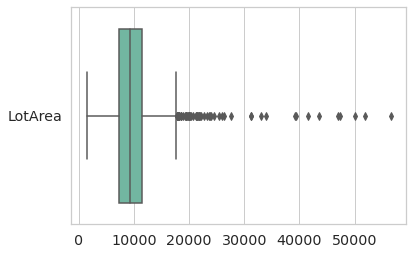

In [594]:
display_box_plot(new_df[['LotArea']]) #checking outlier distribution of column 'LotArea'

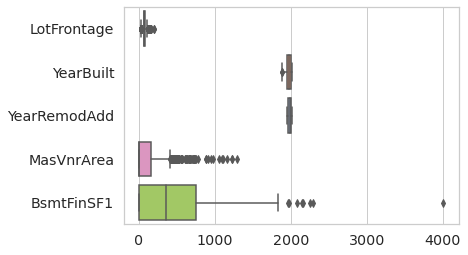

In [595]:
display_box_plot(new_df[['LotFrontage','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1']]) #checking outlier distribution of columns 'LotFrontage','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1'

Identify and remove extreme outliers (less than Q1-3IQR or greater than Q3+3IQR)

In [596]:
out_prod_df = remove_extreme_outliers(new_df)
print (out_prod_df)

     MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition
0            20       RH         80.0  ...    2010       WD        Normal
2            60       RL         74.0  ...    2010       WD        Normal
3            60       RL         78.0  ...    2010       WD        Normal
4           120       RL         43.0  ...    2010       WD        Normal
5            60       RL         75.0  ...    2010       WD        Normal
...         ...      ...          ...  ...     ...      ...           ...
1453        160       RM         21.0  ...    2006       WD        Normal
1454        160       RM         21.0  ...    2006       WD        Normal
1455        160       RM         21.0  ...    2006       WD       Abnorml
1456         20       RL        160.0  ...    2006       WD       Abnorml
1458         60       RL         74.0  ...    2006       WD        Normal

[1318 rows x 76 columns]


Next step is applying OHE to convert text columns into numerical representation

In [597]:
data_df = pd.get_dummies(out_prod_df, drop_first=True)

In [598]:
X_prod = data_df.copy()
print(X_prod.shape)

(1318, 244)


In [599]:
metadata_df.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NA,Attchd,RFn,TA,TA,Y,NA,NA,WD,Normal
1,20,RM,Grvl,Grvl,IR1,Bnk,NoSeWa,FR2,Mod,Veenker,Feedr,RRNn,TwnhsE,1Story,Hip,WdShngl,MetalSd,MetalSd,None,TA,Gd,CBlock,TA,Gd,Gd,ALQ,ALQ,GasW,Gd,N,FuseA,TA,Min1,TA,Detchd,Unf,Fa,Fa,N,GdWo,Shed,New,Abnorml
2,70,C (all),Absent,Pave,IR2,Low,Absent,Corner,Sev,Crawfor,RRAe,Feedr,Duplex,1.5Unf,Gambrel,WdShake,Wd Sdng,Wd Shng,Stone,Ex,Fa,BrkTil,Ex,Fa,Mn,Rec,Rec,Grav,TA,Absent,FuseF,Ex,Maj1,Gd,BuiltIn,Fin,NA,Gd,P,GdPrv,Absent,COD,Partial
3,45,FV,Absent,Absent,IR3,HLS,Absent,CulDSac,Absent,NoRidge,RRNn,PosN,Twnhs,SFoyer,Flat,Membran,HdBoard,HdBoard,BrkCmn,Fa,Ex,Slab,NA,NA,Av,Unf,LwQ,Wall,Fa,Absent,FuseP,Fa,Min2,Fa,CarPort,NA,Gd,NA,Absent,MnPrv,Absent,ConLI,Family
4,120,RH,Absent,Absent,Absent,Absent,Absent,FR3,Absent,Somerst,RRAn,PosA,2fmCon,1.5Fin,Mansard,Tar&Grv,WdShing,Plywood,Absent,Absent,Absent,Stone,Fa,Po,NA,BLQ,BLQ,OthW,Po,Absent,Mix,Absent,Mod,Ex,NA,Absent,Ex,Ex,Absent,MnWw,Absent,CWD,AdjLand


In [600]:
metadata_prod_dict = {}
max_prod_length = 0

In [601]:
for i in out_prod_df.columns:
  if out_prod_df[i].dtype=='O':
    metadata_prod_dict[i] = list(out_prod_df[i].unique())
    print(metadata_prod_dict[i])
    if len(metadata_prod_dict[i]) > max_prod_length:
      max_prod_length = len(metadata_prod_dict[i])

['20', '60', '120', '160', '80', '30', '50', '190', '45', '70', '75', '90', '85', '180', '40']
['RH', 'RL', 'RM', 'FV', 'C (all)']
['Pave', 'Grvl']
['NA', 'Pave', 'Grvl']
['Reg', 'IR1', 'IR2', 'IR3']
['Lvl', 'HLS', 'Bnk', 'Low']
['AllPub']
['Inside', 'Corner', 'FR2', 'CulDSac', 'FR3']
['Gtl', 'Mod', 'Sev']
['NAmes', 'Gilbert', 'StoneBr', 'BrDale', 'NPkVill', 'NridgHt', 'Blmngtn', 'NoRidge', 'Somerst', 'SawyerW', 'Sawyer', 'NWAmes', 'OldTown', 'BrkSide', 'ClearCr', 'SWISU', 'Edwards', 'CollgCr', 'Crawfor', 'Blueste', 'IDOTRR', 'Mitchel', 'Timber', 'MeadowV', 'Veenker']
['Feedr', 'Norm', 'PosN', 'RRNe', 'Artery', 'RRNn', 'PosA', 'RRAn', 'RRAe']
['Norm', 'Feedr', 'PosA', 'PosN', 'Artery']
['1Fam', 'TwnhsE', 'Twnhs', '2fmCon', 'Duplex']
['1Story', '2Story', 'SLvl', '1.5Fin', '2.5Unf', 'SFoyer', '1.5Unf']
['Gable', 'Hip', 'Gambrel', 'Flat', 'Mansard', 'Shed']
['CompShg', 'Tar&Grv', 'WdShake', 'WdShngl']
['VinylSd', 'HdBoard', 'Plywood', 'MetalSd', 'CemntBd', 'Wd Sdng', 'WdShing', 'BrkFace',

In [602]:
for i in metadata_prod_dict.keys():
  padding = ['Absent' for j in range(max_prod_length-len(metadata_prod_dict[i]))]
  metadata_prod_dict[i].extend(padding)

In [603]:
metadata_prod_df = pd.DataFrame(data=metadata_prod_dict)

In [604]:
metadata_prod_df.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition
0,20,RH,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,NA,Attchd,Unf,TA,TA,Y,MnPrv,NA,WD,Normal
1,60,RL,Grvl,Pave,IR1,HLS,Absent,Corner,Mod,Gilbert,Norm,Feedr,TwnhsE,2Story,Hip,Tar&Grv,HdBoard,HdBoard,BrkFace,Gd,Fa,PConc,Gd,Fa,Gd,GLQ,Unf,GasW,Gd,N,FuseA,Gd,Min2,TA,Detchd,Fin,NA,NA,N,NA,Shed,COD,Partial
2,120,RM,Absent,Grvl,IR2,Bnk,Absent,FR2,Sev,StoneBr,PosN,PosA,Twnhs,SLvl,Gambrel,WdShake,Plywood,Plywood,Stone,Ex,Gd,BrkTil,Ex,Gd,Mn,ALQ,Rec,Wall,Ex,Absent,FuseF,Ex,Min1,Gd,BuiltIn,RFn,Fa,Fa,P,GdPrv,Absent,New,Abnorml
3,160,FV,Absent,Absent,IR3,Low,Absent,CulDSac,Absent,BrDale,RRNe,PosN,2fmCon,1.5Fin,Flat,WdShngl,MetalSd,MetalSd,BrkCmn,Fa,Ex,Stone,Fa,NA,Av,Unf,BLQ,Absent,Fa,Absent,FuseP,Fa,Mod,Po,Basment,NA,Gd,Gd,Absent,GdWo,Absent,ConLD,Family
4,80,C (all),Absent,Absent,Absent,Absent,Absent,FR3,Absent,NPkVill,Artery,Artery,Duplex,2.5Unf,Mansard,Absent,CemntBd,Brk Cmn,Absent,Absent,Po,Slab,NA,Absent,NA,BLQ,GLQ,Absent,Po,Absent,Absent,Absent,Maj2,Fa,NA,Absent,Po,Po,Absent,MnWw,Absent,Con,Alloca


In [605]:
metadata_df[~metadata_df.MSSubClass.isin(metadata_prod_df.MSSubClass)]['MSSubClass']

Series([], Name: MSSubClass, dtype: object)

In [606]:
metadata_df[~metadata_df['MSSubClass'].isin(metadata_prod_df['MSSubClass'])]['MSSubClass']

Series([], Name: MSSubClass, dtype: object)

In [607]:
#Train Metadata Minus Prod Metadata
for i in metadata_df.columns:
  s = metadata_df[~metadata_df[i].isin(metadata_prod_df[i])][i]
  if s.empty==False:
    print(i," ---->> ",s.values)

Utilities  ---->>  ['NoSeWa']
Condition2  ---->>  ['RRNn']
HouseStyle  ---->>  ['2.5Fin']
RoofMatl  ---->>  ['Membran']
Exterior1st  ---->>  ['Stone' 'ImStucc']
Exterior2nd  ---->>  ['AsphShn' 'Stone']
BsmtCond  ---->>  ['Po']
Heating  ---->>  ['Grav' 'OthW' 'Floor']
Electrical  ---->>  ['Mix']
Functional  ---->>  ['Sev']
GarageQual  ---->>  ['Ex']


In [608]:
cat_prod_missing_in_train = {}
#Prod Metadata Minus Train Metadata
for i in metadata_prod_df.columns:
  s = metadata_prod_df[~metadata_prod_df[i].isin(metadata_df[i])][i]
  if s.empty==False:
    print(i," ---->> ",s.values)
    cat_prod_missing_in_train[i] = [element for element in s.values]

Condition2  ---->>  ['Artery']
Exterior1st  ---->>  ['Other']
ExterCond  ---->>  ['Po']


In [609]:
cat_prod_missing_in_train

{'Condition2': ['Artery'], 'ExterCond': ['Po'], 'Exterior1st': ['Other']}

__After finding minus of categorical values for each column we need to remove additional rows from prod data before undergoing dummies. Addition of completely empty dummy columns for values missing in prod data has to be done after dummies.__

Dataframe _out_prod_df_ needs to be treated by removing those records that have some categorical value that was absent in train data (_out_df_)

In [610]:
out_prod_df.shape

(1318, 76)

In [611]:
for i in cat_prod_missing_in_train.keys():
  for j in range(len(cat_prod_missing_in_train[i])):
    print(f"Value '{cat_prod_missing_in_train[i][j]}' is present in prod data but was absent from train data for column '{i}'")
    print(out_prod_df[out_prod_df[i]==cat_prod_missing_in_train[i][j]][out_prod_df.columns])
    out_prod_df = out_prod_df.loc[~(out_prod_df[i]==cat_prod_missing_in_train[i][j]),:]

Value 'Artery' is present in prod data but was absent from train data for column 'Condition2'
    MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition
650         50       RM         54.0  ...    2008       WD       Abnorml
778         20       RL         77.0  ...    2008       WD       Abnorml
995         50       RM         55.0  ...    2007       WD        Normal

[3 rows x 76 columns]
Value 'Other' is present in prod data but was absent from train data for column 'Exterior1st'
    MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition
691         30       RL         85.0  ...    2008       WD        Normal

[1 rows x 76 columns]
Value 'Po' is present in prod data but was absent from train data for column 'ExterCond'
    MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition
756         20       RL         80.0  ...    2008       WD       Abnorml

[1 rows x 76 columns]


In [612]:
out_prod_df.shape

(1313, 76)

In [613]:
#this code is just for exploration - no functionality added
for i in cat_prod_missing_in_train.keys():
  print(i)
  for j in range(len(cat_prod_missing_in_train[i])):
    col = '_'.join([i,cat_prod_missing_in_train[i][j]])
    print(col)

Condition2
Condition2_Artery
Exterior1st
Exterior1st_Other
ExterCond
ExterCond_Po


After get_dummies() if we directly compare columns between train and prod data then we easily get the set minus operation results. However the idea is to do all sorts of cleaning at the beginning and not wait till the point of get_dummies(). Here below comparison helps us to verify the results of our code.

In [614]:
'''
[item for item in X.columns if item not in X_prod.columns]
['Utilities_NoSeWa',
 'Condition2_RRNn',
 'HouseStyle_2.5Fin',
 'RoofMatl_Membran',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_AsphShn',
 'Exterior2nd_Stone',
 'BsmtCond_Po',
 'Heating_GasA',
 'Heating_Grav',
 'Heating_OthW',
 'Electrical_Mix',
 'Functional_Sev',
 'GarageQual_Fa']
 '''

"\n[item for item in X.columns if item not in X_prod.columns]\n['Utilities_NoSeWa',\n 'Condition2_RRNn',\n 'HouseStyle_2.5Fin',\n 'RoofMatl_Membran',\n 'Exterior1st_ImStucc',\n 'Exterior1st_Stone',\n 'Exterior2nd_AsphShn',\n 'Exterior2nd_Stone',\n 'BsmtCond_Po',\n 'Heating_GasA',\n 'Heating_Grav',\n 'Heating_OthW',\n 'Electrical_Mix',\n 'Functional_Sev',\n 'GarageQual_Fa']\n "

In [615]:
'''
[item for item in X_prod.columns if item not in X.columns]
['Condition2_Feedr', 'Exterior1st_Other', 'ExterCond_Po']
'''

"\n[item for item in X_prod.columns if item not in X.columns]\n['Condition2_Feedr', 'Exterior1st_Other', 'ExterCond_Po']\n"

After removal of extra records from prod data, we do get_dummies(). Then we check if the set minus operations lead to expected result or some other common categorical value got removed from prod data. If all is good, then we proceed with addition of new dummy columns for categorical values absent from prod data.

In [616]:
data_df = pd.get_dummies(out_prod_df, drop_first=True)

In [617]:
X_prod = data_df.copy()
print(X_prod.shape)

(1313, 239)


In [618]:
columns_in_train_not_in_prod = [item for item in X.columns if item not in X_prod.columns]
columns_in_train_not_in_prod

['Utilities_NoSeWa',
 'Condition2_RRNn',
 'HouseStyle_2.5Fin',
 'RoofMatl_Membran',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_AsphShn',
 'Exterior2nd_Other',
 'Exterior2nd_Stone',
 'BsmtCond_Po',
 'Heating_GasA',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'Electrical_Mix',
 'Functional_Sev',
 'GarageQual_Fa']

In [619]:
[item for item in X_prod.columns if item not in X.columns]

[]

In [620]:
add_column_df = pd.DataFrame(np.zeros((X_prod.shape[0],len(columns_in_train_not_in_prod))), columns=columns_in_train_not_in_prod)
print(add_column_df.shape)
add_column_df.head()

(1313, 17)


,Utilities_NoSeWa,Condition2_RRNn,HouseStyle_2.5Fin,RoofMatl_Membran,Exterior1st_ImStucc,Exterior1st_Stone,Exterior2nd_AsphShn,Exterior2nd_Other,Exterior2nd_Stone,BsmtCond_Po,Heating_GasA,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_Mix,Functional_Sev,GarageQual_Fa
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [621]:
#prod data after outlier and extra categorical value removal (rows removed) had indexes not in sequential order. This could give issue when concating, so we reindex
X_prod.reset_index(inplace=True)
X_prod

,index,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,...,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_Shed,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961,1.0,730.0,140,0,0,0,120,0,6,2010,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,2,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997,2.0,482.0,212,34,0,0,0,0,3,2010,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,3,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998,2.0,470.0,360,36,0,0,0,0,6,2010,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,4,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992,2.0,506.0,0,82,0,0,144,0,1,2010,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,5,75.0,10000,6,5,1993,1994,0.0,0.0,0.0,763.0,763,892,0,1655,0.0,0.0,2,1,3,1,7,1,1993,2.0,440.0,157,84,0,0,0,0,4,2010,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,1453,21.0,1526,4,5,1970,1970,0.0,0.0,0.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,0,0.0,0.0,0,34,0,0,0,0,6,2006,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1309,1454,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,0,0.0,0.0,0,0,0,0,0,0,6,2006,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1310,1455,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,294.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,1970,1.0,286.0,0,24,0,0,0,0,4,2006,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1311,1456,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,0.0,1224,0,0,1224,1.0,0.0,1,0,4,1,7,1,1960,2.0,576.0,474,0,0,0,0,0,9,2006,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [622]:
X_prod.drop(['index'], axis=1, inplace=True)
X_prod.shape

(1313, 239)

In [623]:
#We use concat() to add all the freshly created columns (for missing categorical value in prod data) to the existing prod data
X_prod_final = pd.concat([X_prod, add_column_df], axis=1)

print(X_prod_final.shape)
X_prod_final.head()

(1313, 256)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,...,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_Shed,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Utilities_NoSeWa,Condition2_RRNn,HouseStyle_2.5Fin,RoofMatl_Membran,Exterior1st_ImStucc,Exterior1st_Stone,Exterior2nd_AsphShn,Exterior2nd_Other,Exterior2nd_Stone,BsmtCond_Po,Heating_GasA,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_Mix,Functional_Sev,GarageQual_Fa
0,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961,1.0,730.0,140,0,0,0,120,0,6,2010,0,0,0,1,0,0,0,...,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997,2.0,482.0,212,34,0,0,0,0,3,2010,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998,2.0,470.0,360,36,0,0,0,0,6,2010,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992,2.0,506.0,0,82,0,0,144,0,1,2010,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,75.0,10000,6,5,1993,1994,0.0,0.0,0.0,763.0,763,892,0,1655,0.0,0.0,2,1,3,1,7,1,1993,2.0,440.0,157,84,0,0,0,0,4,2010,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


__We need to arrange the columns correctly__

In [624]:
#Fetch list of columns for train data X
X_list = X.columns.tolist()

In [625]:
#Rearrange columns in prod data, i.e. X_prod_final according to the column ordering of train data X
X_prod_final = X_prod_final[X_list]

In [626]:
#Compare column order of train data X vs that of prod data X_prod_final - there should be no mismatch
X_prod_final_list = X_prod_final.columns.to_list()
for i in range(len(X.columns)):
  if X_list[i] != X_prod_final_list[i]:
    print(i)

In [627]:
X_prod_final.shape

(1313, 256)

In [628]:
X_prod_final.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,...,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_Shed,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961,1.0,730.0,140,0,0,0,120,0,6,2010,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1,0.0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997,2.0,482.0,212,34,0,0,0,0,3,2010,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998,2.0,470.0,360,36,0,0,0,0,6,2010,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992,2.0,506.0,0,82,0,0,144,0,1,2010,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0.0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,75.0,10000,6,5,1993,1994,0.0,0.0,0.0,763.0,763,892,0,1655,0.0,0.0,2,1,3,1,7,1,1993,2.0,440.0,157,84,0,0,0,0,4,2010,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


Just before Prediction we apply Standard Scalar Transformation on the Independent Variables

In [629]:
from sklearn.preprocessing import StandardScaler
X_prod_final = pd.DataFrame(StandardScaler().fit_transform(X_prod_final), columns=X_prod_final.columns)

X_prod_final.head()


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,...,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_Shed,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.503510,0.371540,-0.799212,0.406008,-0.384397,-1.118922,-0.580826,0.055579,0.514760,-0.669827,-0.647951,-0.783199,0.0,-1.210962,-0.843683,-0.253103,-1.015510,-0.789454,-1.059348,0.0,-0.921844,-0.929112,0.154802,-1.059229,1.184354,0.392565,-0.760004,-0.376257,0.0,1.739084,0.0,-0.020918,1.725918,-0.226365,-0.067754,-0.121174,1.254795,-0.233706,-0.039058,-0.067754,...,-0.501665,0.816237,-0.111068,-0.272888,-0.061827,-0.602866,-0.198968,-0.198968,-0.620501,1.170485,0.0,-0.083077,-0.198968,-0.039058,0.331497,-0.158052,-0.061827,-0.198968,-0.055279,0.274496,-0.150285,0.335726,-0.203069,2.733307,-0.027608,-1.998098,-0.027608,-0.078296,-0.039058,-0.1075,-0.047855,-0.047855,-0.306866,-0.047855,0.404978,-0.061827,-0.073211,-0.136452,0.452313,-0.311302
1,0.224443,0.814509,-0.799212,-0.516290,0.800453,0.641159,-0.580826,0.781024,-0.298254,-0.985076,-0.565739,0.902897,0.0,0.325202,-0.843683,-0.253103,0.831256,1.235064,0.261567,0.0,-0.203517,0.624931,0.248754,0.281916,0.010194,0.985372,-0.231768,-0.376257,0.0,-0.314333,0.0,-1.134354,1.725918,-0.226365,-0.067754,-0.121174,-0.796943,-0.233706,-0.039058,-0.067754,...,1.993360,0.816237,-0.111068,-0.272888,-0.061827,-0.602866,-0.198968,-0.198968,-0.620501,-0.854346,0.0,-0.083077,-0.198968,-0.039058,0.331497,-0.158052,-0.061827,-0.198968,-0.055279,0.274496,-0.150285,0.335726,-0.203069,2.733307,-0.027608,-1.998098,-0.027608,-0.078296,-0.039058,-0.1075,-0.047855,-0.047855,-0.306866,-0.047855,0.404978,-0.061827,-0.073211,-0.136452,0.452313,-0.311302
2,0.410488,0.041722,-0.105646,0.406008,0.833366,0.641159,-0.468759,0.356538,-0.298254,-0.541831,-0.570877,0.847576,0.0,0.272809,-0.843683,-0.253103,0.831256,1.235064,0.261567,0.0,0.514810,0.624931,0.251363,0.281916,-0.046620,2.203920,-0.200695,-0.376257,0.0,-0.314333,0.0,-0.020918,1.725918,-0.226365,-0.067754,-0.121174,-0.796943,-0.233706,-0.039058,-0.067754,...,-0.501665,0.816237,-0.111068,-0.272888,-0.061827,-0.602866,-0.198968,-0.198968,-0.620501,-0.854346,0.0,-0.083077,-0.198968,-0.039058,0.331497,-0.158052,-0.061827,-0.198968,-0.055279,0.274496,-0.150285,0.335726,-0.203069,-0.365857,-0.027608,0.500476,-0.027608,-0.078296,-0.039058,-0.1075,-0.047855,-0.047855,-0.306866,-0.047855,0.404978,-0.061827,-0.073211,-0.136452,0.452313,-0.311302
3,-1.217400,-0.955960,1.281487,-0.516290,0.635891,0.355741,-0.580826,-0.404842,-0.298254,1.100786,0.338589,-0.783199,0.0,-0.406205,-0.843683,-0.253103,0.831256,-0.789454,-1.059348,0.0,-0.921844,-0.929112,0.235705,0.281916,0.123822,-0.760116,0.513978,-0.376257,0.0,2.149768,0.0,-1.876645,1.725918,-0.226365,-0.067754,-0.121174,-0.796943,-0.233706,-0.039058,-0.067754,...,-0.501665,0.816237,-0.111068,-0.272888,-0.061827,-0.602866,-0.198968,-0.198968,1.611602,-0.854346,0.0,-0.083077,-0.198968,-0.039058,0.331497,-0.158052,-0.061827,-0.198968,-0.055279,0.274496,-0.150285,0.335726,-0.203069,-0.365857,-0.027608,0.500476,-0.027608,-0.078296,-0.039058,-0.1075,-0.047855

__Prediction on Test Data based on the Model previously trained__

For the purpose of prediction we use the best model that we had trained. It is the one which had minimum score (RMSE). It is the blended model we created.

In [630]:
np.expm1(blended_predictions(X_prod_final))[:20]

array([127321.78274862, 180427.32951991, 196534.33408489, 193998.0061009 ,
       176772.7405045 , 166050.50738051, 186056.58724975, 121149.53735533,
       193263.58038458,  95493.72560836,  98081.07913943, 149420.33198183,
       125777.85075712, 389713.55962634, 254360.80267516, 298321.48256536,
       284128.69095549, 536679.62827209, 333750.36014192, 209585.77471742])

In [631]:
np.expm1(blended_predictions(X_prod_final)).mean()

182465.9001192554

In [632]:
train_df['SalePrice'].mean()

180921.19589041095

In [633]:
np.expm1(blended_predictions(X_prod_final)).std()

78642.41665767824

In [634]:
train_df['SalePrice'].std()

79442.50288288663

__Conclusion__

*   The House Price Training data as well as the Test data (which we consider as production data or new data) both had a wide range of null values
*   Missing value imputation was done after thorough data analysis of the column itself as well as related columns (from domain perspective)
*   The dependent variable had a skewed distribution, meaning a log transformation was done to get it to a normal distribution
*   Feature selection was minimal with occassional less significant column being dropped
*   Extreme outliers were removed from both Train and Test
*   Metadata validation was done rigorously for Test data based on that collected from Train data
*   Categorical values coming first time in Test were not fed in to the model as it was completely unseen for the model. For categorical values in Train but absent from Test, dummy (empty) columns were added to make the Train data suitable for Prediction
*   The Train data was split into further subsets for training and testing of the model. However the models built did not give good evaluation metric scores, implying that this generic data split was not good for the model learning.
*   The approach hence taken, was applying Cross Validation with k=12 over the full Train data to train our models.
*   Evaluation metric scores after Cross Validation were highest for algorithms like Ridge Regression, XG Boosted Regression, Gradient Boosted Regression and Random Forest Regression. However after creating a blended model using the better models we got significant rise in the metric score
*   Finally we used this blended model (generally gives more stable predictions) to make predictions on the Test data
*   There is no direct way to validate our final predictions on the Test (new) data. However when we compared the distribution (mean and standard deviation) of the dependent variable 'SalePrice', between Train and Test (our Predicted column) the values were quite close.

